In [1]:
!pip install -q nltk wordcloud textblob contractions

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
import string
import nltk
import contractions
from wordcloud import WordCloud
from textblob import TextBlob
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

In [3]:
nltk.download('stopwords')
from nltk.corpus import stopwords

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\khush\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping corpora\stopwords.zip.


In [4]:
df = pd.read_csv('reddit_artist_posts_sentiment.csv')
df.head()

,text,label
0,pitchfork track review: taylor swift’s “actual...,negative
1,taylor swift has regained the masters of her f...,positive
2,pitchfork review: taylor swift - the life of a...,neutral
3,taylor swift announced engagement,neutral
4,taylor swift - the fate of ophelia (official m...,neutral


In [5]:
df.shape

(31948, 2)

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 31948 entries, 0 to 31947
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   text    31948 non-null  object
 1   label   31948 non-null  object
dtypes: object(2)
memory usage: 499.3+ KB


In [7]:
df.isnull().sum()

text     0
label    0
dtype: int64

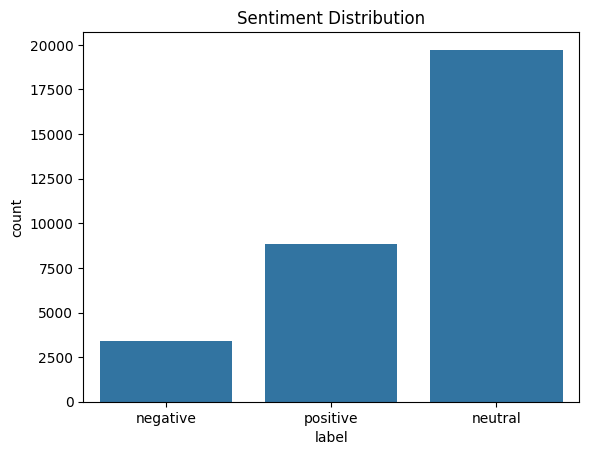

In [8]:
sns.countplot(x='label', data=df)
plt.title("Sentiment Distribution")
plt.show()

In [9]:
df = df.dropna()
df['label'] = df['label'].str.lower().str.strip()
df.head()

,text,label
0,pitchfork track review: taylor swift’s “actual...,negative
1,taylor swift has regained the masters of her f...,positive
2,pitchfork review: taylor swift - the life of a...,neutral
3,taylor swift announced engagement,neutral
4,taylor swift - the fate of ophelia (official m...,neutral


In [10]:
label_map = {
    "negative": 0,
    "neutral": 1,
    "positive": 2
}

df['sentiment'] = df['label'].map(label_map)
df.head()

,text,label,sentiment
0,pitchfork track review: taylor swift’s “actual...,negative,0
1,taylor swift has regained the masters of her f...,positive,2
2,pitchfork review: taylor swift - the life of a...,neutral,1
3,taylor swift announced engagement,neutral,1
4,taylor swift - the fate of ophelia (official m...,neutral,1


In [11]:
stop_words = set(stopwords.words('english'))

def clean_text(text):
    text = contractions.fix(str(text))
    text = text.lower()
    text = re.sub(r"http\S+", "", text)
    text = re.sub(r"@\w+|#\w+", "", text)
    text = re.sub(r"\d+", "", text)
    text = text.translate(str.maketrans("", "", string.punctuation))
    text = text.strip()
    words = text.split()
    words = [w for w in words if w not in stop_words]
    return " ".join(words)

df['cleaned_text'] = df['text'].apply(clean_text)
df.head()

,text,label,sentiment,cleaned_text
0,pitchfork track review: taylor swift’s “actual...,negative,0,pitchfork track review taylor swift’s “actuall...
1,taylor swift has regained the masters of her f...,positive,2,taylor swift regained masters first six albums
2,pitchfork review: taylor swift - the life of a...,neutral,1,pitchfork review taylor swift life showgirl
3,taylor swift announced engagement,neutral,1,taylor swift announced engagement
4,taylor swift - the fate of ophelia (official m...,neutral,1,taylor swift fate ophelia official music video


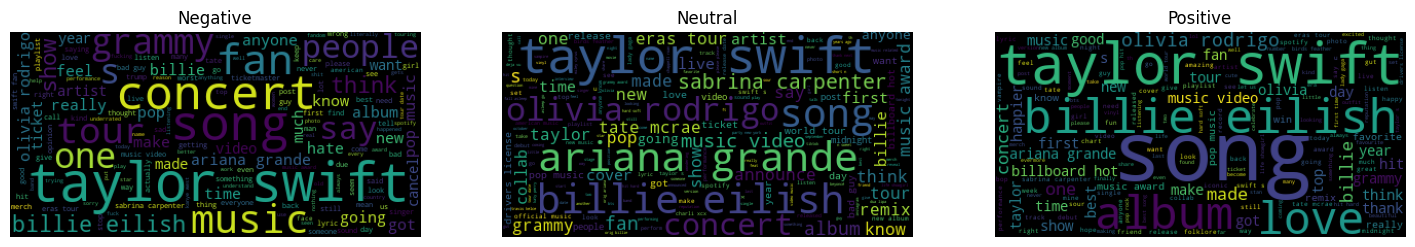

In [12]:
neg_text = " ".join(df[df['sentiment']==0]['cleaned_text'])
neu_text = " ".join(df[df['sentiment']==1]['cleaned_text'])
pos_text = " ".join(df[df['sentiment']==2]['cleaned_text'])

plt.figure(figsize=(18,5))

plt.subplot(1,3,1)
plt.title("Negative")
plt.imshow(WordCloud(background_color='black').generate(neg_text))
plt.axis("off")

plt.subplot(1,3,2)
plt.title("Neutral")
plt.imshow(WordCloud(background_color='black').generate(neu_text))
plt.axis("off")

plt.subplot(1,3,3)
plt.title("Positive")
plt.imshow(WordCloud(background_color='black').generate(pos_text))
plt.axis("off")

plt.show()

In [13]:
X = df['cleaned_text']
y = df['sentiment']

vectorizer = TfidfVectorizer(max_features=6000)
X = vectorizer.fit_transform(X)

In [14]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.20, random_state=42, stratify=y
)

In [15]:
model = LogisticRegression(multi_class='multinomial', max_iter=500)
model.fit(X_train, y_train)

c:\Users\khush\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\linear_model\_logistic.py:1272: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.8. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


,penalty,'l2'
,dual,False
,tol,0.0001
,C,1.0
,fit_intercept,True
,intercept_scaling,1
,class_weight,None
,random_state,None
,solver,'lbfgs'
,max_iter,500
,multi_class,'multinomial'


In [16]:
y_pred = model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)

print("Model Accuracy:", round(accuracy*100, 2), "%")

Model Accuracy: 75.7 %


In [17]:
print(classification_report(
    y_test, y_pred, 
    target_names=["Negative", "Neutral", "Positive"]
))

              precision    recall  f1-score   support

    Negative       0.68      0.31      0.42       679
     Neutral       0.76      0.91      0.83      3946
    Positive       0.76      0.58      0.66      1765

    accuracy                           0.76      6390
   macro avg       0.73      0.60      0.64      6390
weighted avg       0.75      0.76      0.74      6390



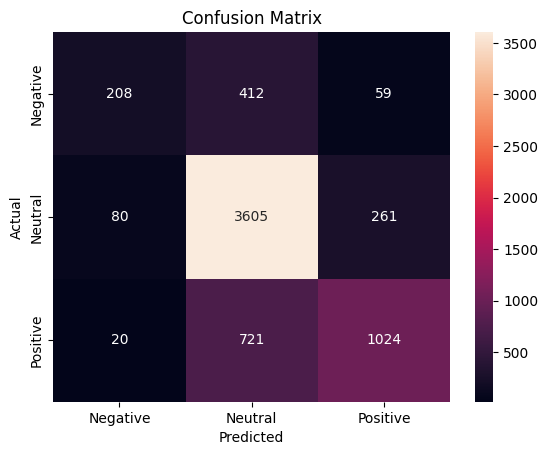

In [18]:
cm = confusion_matrix(y_test, y_pred)

sns.heatmap(cm, annot=True, fmt='d',
            xticklabels=["Negative","Neutral","Positive"],
            yticklabels=["Negative","Neutral","Positive"])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

In [19]:
def predict_sentiment(text):
    text = clean_text(text)
    vec = vectorizer.transform([text])
    pred = model.predict(vec)[0]
    
    if pred == 0:
        return "Negative 😠"
    elif pred == 1:
        return "Neutral 😐"
    else:
        return "Positive 😊"

In [20]:
predict_sentiment("Taylor Swift just broke another Billboard record!")

'Neutral 😐'

In [21]:
from sklearn.svm import LinearSVC

model = LinearSVC()
model.fit(X_train, y_train)

,penalty,'l2'
,loss,'squared_hinge'
,dual,'auto'
,tol,0.0001
,C,1.0
,multi_class,'ovr'
,fit_intercept,True
,intercept_scaling,1
,class_weight,None
,verbose,0
,random_state,None


In [22]:
y_pred = model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)

print("Model Accuracy:", round(accuracy*100, 2), "%")

Model Accuracy: 76.4 %


In [23]:
print(classification_report(
    y_test, y_pred,
    target_names=["Negative", "Neutral", "Positive"]
))

              precision    recall  f1-score   support

    Negative       0.63      0.44      0.52       679
     Neutral       0.79      0.88      0.83      3946
    Positive       0.73      0.63      0.68      1765

    accuracy                           0.76      6390
   macro avg       0.72      0.65      0.68      6390
weighted avg       0.76      0.76      0.76      6390



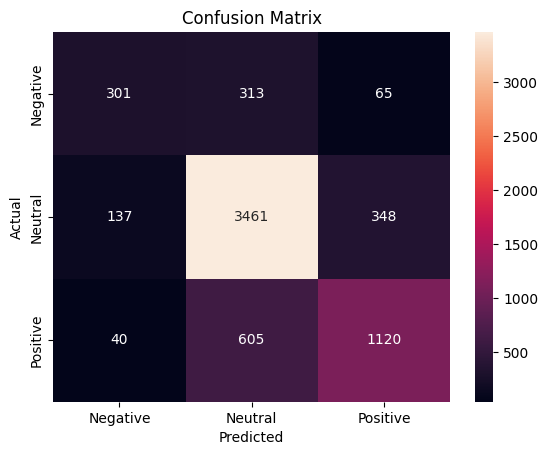

In [24]:
cm = confusion_matrix(y_test, y_pred)

sns.heatmap(cm, annot=True, fmt='d',
            xticklabels=["Negative","Neutral","Positive"],
            yticklabels=["Negative","Neutral","Positive"])

plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()